# Common Constants

In [1]:
from run_battery import BatteryRunner, BatteryConfigs

runner = BatteryRunner.of(BatteryConfigs.Bugs2Fix)

In [2]:
runner.load_cases()

Loaded 100 cases!


In [3]:
from model_wrapper import ModelFamily

# Generate Output

In [4]:
runner.run_battery(
    family=ModelFamily.CodeGen1.multi,
    patch=False,
    # patch=True,
)

HTML(value="<h1 style='font-weight: bold; border-bottom: 1px solid;'>Testing prompt index 0</h1>")

# Testing prompt index 0
Prompt to be tested:
// the buggy version of the code
{prompt}
// the fixed version of the code



HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 350M (Salesforce/codegen-350M-mu…

## Loading 350M (Salesforce/codegen-350M-multi)
No new cases necessary to generate, not loading model


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 2B (Salesforce/codegen-2B-multi)…

## Loading 2B (Salesforce/codegen-2B-multi)
No new cases necessary to generate, not loading model


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 6B (Salesforce/codegen-6B-multi)…

## Loading 6B (Salesforce/codegen-6B-multi)
No new cases necessary to generate, not loading model


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 16B (Salesforce/codegen-16B-mult…

## Loading 16B (Salesforce/codegen-16B-multi)
No new cases necessary to generate, not loading model


HTML(value="<h1 style='font-weight: bold; border-bottom: 1px solid;'>Testing prompt index 1</h1>")

# Testing prompt index 1
Prompt to be tested:
// You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
{prompt}



HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 350M (Salesforce/codegen-350M-mu…

## Loading 350M (Salesforce/codegen-350M-multi)
No new cases necessary to generate, not loading model


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 2B (Salesforce/codegen-2B-multi)…

## Loading 2B (Salesforce/codegen-2B-multi)
No new cases necessary to generate, not loading model


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 6B (Salesforce/codegen-6B-multi)…

## Loading 6B (Salesforce/codegen-6B-multi)
No new cases necessary to generate, not loading model


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 16B (Salesforce/codegen-16B-mult…

## Loading 16B (Salesforce/codegen-16B-multi)
No new cases necessary to generate, not loading model


HTML(value="<h1 style='font-weight: bold; border-bottom: 1px solid;'>Testing prompt index 2</h1>")

# Testing prompt index 2
Prompt to be tested:
// You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
{prompt}
// The following code is correct:



HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 350M (Salesforce/codegen-350M-mu…

## Loading 350M (Salesforce/codegen-350M-multi)
Opening ./output/bugs2fix/prompt2/codegen1-multi-350M.output...


[2024-06-21@20:07:57|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-06-21@20:07:57|model.device] Time elapsed: 30ms
[2024-06-21@20:07:57|model.tokenizer] Starting timer.
[2024-06-21@20:07:57|model.tokenizer] Time elapsed: 203ms
[2024-06-21@20:07:57|model.model] Starting timer.
Obtaining model...
[2024-06-21@20:08:00|model.model] Time elapsed: 3s 237ms
Done, 5min 11s elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 2B (Salesforce/codegen-2B-multi)…

## Loading 2B (Salesforce/codegen-2B-multi)
Opening ./output/bugs2fix/prompt2/codegen1-multi-2B.output...


[2024-06-21@20:13:08|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-06-21@20:13:08|model.device] Time elapsed: ~0s
[2024-06-21@20:13:08|model.tokenizer] Starting timer.
[2024-06-21@20:13:09|model.tokenizer] Time elapsed: 219ms
[2024-06-21@20:13:09|model.model] Starting timer.
Obtaining model...
[2024-06-21@20:13:44|model.model] Time elapsed: 35s 73ms
Done, 8min 86ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 6B (Salesforce/codegen-6B-multi)…

## Loading 6B (Salesforce/codegen-6B-multi)
Opening ./output/bugs2fix/prompt2/codegen1-multi-6B.output...


[2024-06-21@20:21:09|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-06-21@20:21:09|model.device] Time elapsed: ~0s
[2024-06-21@20:21:09|model.tokenizer] Starting timer.
[2024-06-21@20:21:09|model.tokenizer] Time elapsed: 289ms
[2024-06-21@20:21:09|model.model] Starting timer.
Obtaining model...


[2024-06-21@20:22:34|model.model] Time elapsed: 1min 25s
Done, 1hr 46min 59s elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 16B (Salesforce/codegen-16B-mult…

## Loading 16B (Salesforce/codegen-16B-multi)
Opening ./output/bugs2fix/prompt2/codegen1-multi-16B.output...


[2024-06-21@22:08:09|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-06-21@22:08:09|model.device] Time elapsed: ~0s
[2024-06-21@22:08:09|model.tokenizer] Starting timer.
[2024-06-21@22:08:09|model.tokenizer] Time elapsed: 180ms
[2024-06-21@22:08:09|model.model] Starting timer.
Obtaining model...


[2024-06-21@22:08:47|model.model] Time elapsed: 37s 666ms
Done, 11hr 27min 56s elapsed.


# Interpret Output

In [4]:
import metric
runner.init_render(family=ModelFamily.CodeGen1.multi)

## Combined Graphs

Saved figure to ./figs/b2f-all.png


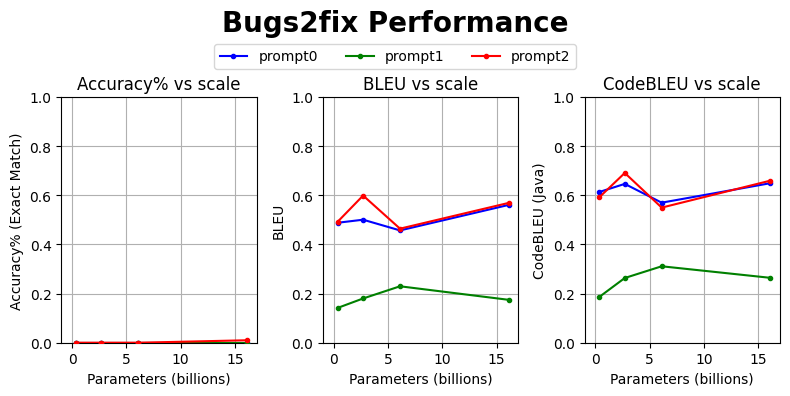

[{'prompt0': [0.0, 0.0, 0.0, 0.0],
  'prompt1': [0.0, 0.0, 0.0, 0.0],
  'prompt2': [0.0, 0.0, 0.0, 0.01]},
 {'prompt0': [0.48820137569847905,
   0.5006341113747632,
   0.45705067969834523,
   0.5606953700959482],
  'prompt1': [0.14156945771243312,
   0.18010279725351888,
   0.22966604098260265,
   0.17465742390969388],
  'prompt2': [0.49204938063614584,
   0.5989108295800651,
   0.4641603674764887,
   0.5688964125027325]},
 {'prompt0': [0.6133823854504274,
   0.6463875095979323,
   0.5699422358685238,
   0.6491634904813729],
  'prompt1': [0.18617262820091549,
   0.2634117729357921,
   0.31108544782004577,
   0.26415028332874624],
  'prompt2': [0.5917528825148218,
   0.6908598542659203,
   0.5498833751741166,
   0.6594912699189425]}]

In [5]:
runner.render_metric_multi(
    [ metric.ExactMatch, metric.BLEU, metric.CodeBLEUJava ],
    save="./figs/b2f-all.png",
)

## Individual Graphs

Saved figure to ./figs/b2f-1.png


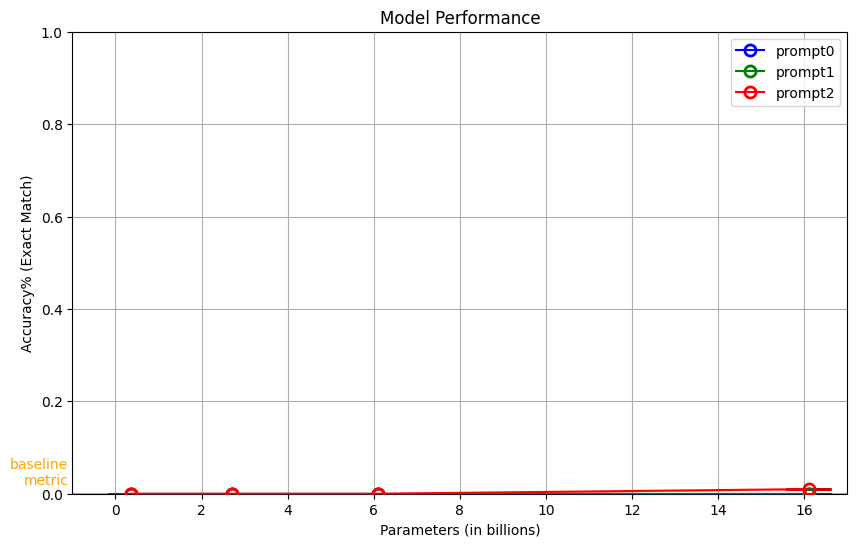

{'prompt0': [[0.0], [0.0], [0.0], [0.0]],
 'prompt1': [[0.0], [0.0], [0.0], [0.0]],
 'prompt2': [[0.0], [0.0], [0.0], [0.01]]}

In [7]:
runner.render_metric(metric.ExactMatch, save="./figs/b2f-1.png")
runner.render_metric(metric.BLEU, save="./figs/b2f-2.png")
runner.render_metric(metric.CodeBLEUJava, save="./figs/b2f-3.png")